In [ ]:
!pip install transformers datasets torchaudio --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Transformers library
from transformers import (
    Wav2Vec2ForSequenceClassification,
    Wav2Vec2Processor,
    Wav2Vec2FeatureExtractor,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

In [ ]:
# PyTorch
import torch
from torch.utils.data import DataLoader

# Dataset handling
from datasets import Dataset, Audio

# Metrics
from sklearn.metrics import accuracy_score
import numpy as np

# File handling
import os
import shutil
import json

# Audio processing
import soundfile as sf

# Randomization
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls '/content/drive/MyDrive/Deep_Project/'

AugmentedData.json  new_data@            test_data.json            wav2vec2-lora-adapter_/
Data@               RoyPlayingWithData/  wav2vec2-base_/
labeled_data.json   saved_models/        wav2vec2-base-finetuned/
lora@               TestData@            wav2vec2-lora/


#Here we train (AGAIN) on the Augmented DATASET, but with LoRa:

In [ ]:
import json
from collections import Counter

In [ ]:
#augmented_data_path='/content/drive/My Drive/AugmentedData'
# ROY CHANGED FOLDER
output_file = "/content/drive/MyDrive/Deep_Project/AugmentedData.json"

In [ ]:
import os
print(os.path.exists(output_file))  # Should return True

True


In [ ]:
# Load the JSON file
with open(output_file, "r") as f:
    data = json.load(f)

# Print the first 5 samples
print("First 5 samples:")
for sample in data[:5]:
    print(sample)

# Check the total number of samples
num_samples = len(data)
print(f"\nTotal number of samples: {num_samples}")

# Inspect keys in one sample
if num_samples > 0:
    print("\nKeys in a sample:")
    print(list(data[0].keys()))
    print("\nExample sample:")
    print(data[0])

# Check accent distribution
accent_distribution = Counter([entry["accent"] for entry in data])
print("\nAccent distribution:")
for accent, count in accent_distribution.items():
    print(f"{accent}: {count}")

First 5 samples:
{'file_path': '/content/drive/My Drive/Deep_Project/RoyPlayingWithData/speaker1/arctic_b0418_vtlp.wav', 'speaker': 'speaker1', 'accent': 'Arabic'}
{'file_path': '/content/drive/My Drive/Deep_Project/RoyPlayingWithData/speaker1/arctic_b0121_time_stretch.wav', 'speaker': 'speaker1', 'accent': 'Arabic'}
{'file_path': '/content/drive/My Drive/Deep_Project/RoyPlayingWithData/speaker1/arctic_a0474_pitch_shift.wav', 'speaker': 'speaker1', 'accent': 'Arabic'}
{'file_path': '/content/drive/My Drive/Deep_Project/RoyPlayingWithData/speaker1/arctic_b0029_pitch_shift.wav', 'speaker': 'speaker1', 'accent': 'Arabic'}
{'file_path': '/content/drive/My Drive/Deep_Project/RoyPlayingWithData/speaker1/arctic_b0194_pitch_shift.wav', 'speaker': 'speaker1', 'accent': 'Arabic'}

Total number of samples: 786

Keys in a sample:
['file_path', 'speaker', 'accent']

Example sample:
{'file_path': '/content/drive/My Drive/Deep_Project/RoyPlayingWithData/speaker1/arctic_b0418_vtlp.wav', 'speaker': 'sp

#Validate the dataset

In [ ]:
import soundfile as sf

In [ ]:
def is_valid_audio(file_path, current_speaker=None, last_speaker=None):
    try:
        # Log progress when the speaker changes
        if current_speaker != last_speaker:
            print(f"Processing files for speaker: {current_speaker}")

        # Open the file in "read mode" without loading it fully
        with sf.SoundFile(file_path, mode="r") as f:
            pass  # Successfully opened, no need to read data
        return True, current_speaker

    except Exception as e:
        # Log the problematic file and speaker
        print(f"Invalid file detected for speaker {current_speaker}: {file_path}, Error: {e}")
        return False, current_speaker

In [ ]:
# Maximum number of files per speaker
MAX_FILES_PER_SPEAKER = 100

# Initialize a dictionary to track the number of files processed per speaker
speaker_file_count = {}

valid_data = []  # Store valid files

for item in data:
    speaker = item["speaker"]

    # Initialize the counter for the speaker if not already done
    if speaker not in speaker_file_count:
        speaker_file_count[speaker] = 0

    # Skip files if the maximum limit is reached for the speaker
    if speaker_file_count[speaker] >= MAX_FILES_PER_SPEAKER:
        continue

    # Check the validity of the file
    is_valid, current_speaker = is_valid_audio(
        item["file_path"],
        current_speaker=speaker,
        last_speaker=None,  # Not needed for this use case
    )

    if is_valid:
        valid_data.append(item)
        speaker_file_count[speaker] += 1  # Increment the counter for the speaker

print(f"Valid data collected for {len(speaker_file_count)} speakers.")

Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for spea

#Make the data compatible to work with huggingface & Add the linear layer to make our model supervised and good for classification

In [ ]:
from transformers import Wav2Vec2FeatureExtractor

In [ ]:
# Convert the filtered data into a Hugging Face Dataset
dataset = Dataset.from_list(valid_data)

# Ensure all audio files are loaded with the correct sampling rate
dataset = dataset.cast_column("file_path", Audio(sampling_rate=16000))

In [ ]:
# Load Wav2Vec2 feature extractor
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-large-xlsr-53")

# Map labels to integers
unique_accents = dataset.unique("accent")
label2id = {label: i for i, label in enumerate(unique_accents)}
id2label = {i: label for label, i in label2id.items()}

# ensure correct accents
print(f"Unique accents: {unique_accents}")
print(f"Label to ID mapping: {label2id}")
print(f"ID to Label mapping: {id2label}")

# Preprocessing function
def preprocess(batch):
    # Load audio and extract input values
    audio = batch["file_path"]["array"]
    inputs = feature_extractor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
    batch["input_values"] = inputs.input_values[0]
    batch["labels"] = label2id[batch["accent"]]
    return batch

# Apply preprocessing
dataset = dataset.map(preprocess, remove_columns=["file_path", "accent", "speaker"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

Unique accents: ['Arabic', 'Spanish']
Label to ID mapping: {'Arabic': 0, 'Spanish': 1}
ID to Label mapping: {0: 'Arabic', 1: 'Spanish'}


Map:   0%|          | 0/761 [00:00<?, ? examples/s]

In [ ]:
# Split the dataset
train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split["train"]
val_dataset = train_test_split["test"]  # Use this for validation during training

# Print the number of samples
print(f"Number of samples in the training set: {len(train_dataset)}")
print(f"Number of samples in the validation set: {len(val_dataset)}")

Number of samples in the training set: 608
Number of samples in the validation set: 153


#LoRa

In [ ]:
pip install peft

In [ ]:
from peft import LoraConfig, get_peft_model, TaskType
from transformers import Wav2Vec2ForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
import numpy as np
from sklearn.metrics import accuracy_score

In [ ]:
# Load your pre-trained model
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-large-xlsr-53",
    num_labels=len(unique_accents),
    label2id=label2id,
    id2label=id2label,
)

# Define LoRA configuration
from peft import LoraConfig, get_peft_model

target_modules = []

# Apply LoRA to specific layers (15 to 23 in the encoder)
for i in range(15, 24):  # Assuming 24 layers in the encoder
    target_modules.extend([
        f"wav2vec2.encoder.layers.{i}.attention.k_proj",
        f"wav2vec2.encoder.layers.{i}.attention.q_proj",
        f"wav2vec2.encoder.layers.{i}.attention.v_proj",
        f"wav2vec2.encoder.layers.{i}.attention.out_proj",
        f"wav2vec2.encoder.layers.{i}.feed_forward.intermediate_dense",
        f"wav2vec2.encoder.layers.{i}.feed_forward.output_dense",
    ])

# Define LoRA configuration
lora_config = LoraConfig(
    r=8,                 # Low-rank adaptation dimension
    lora_alpha=32,       # Scaling factor
    lora_dropout=0.1,    # Dropout rate
    target_modules=target_modules
)

# Apply LoRA
model = get_peft_model(model, lora_config)


In [ ]:
for name, param in model.named_parameters():
    if (
        "lora_A" in name or "lora_B" in name or  # Always keep LoRA weights trainable
        any(
            layer in name for layer in [
                f"wav2vec2.encoder.layers.{i}" for i in range(8, 24)  # Train layers 8–23
            ]
        )
    ):
        param.requires_grad = True
    else:
        param.requires_grad = False

In [ ]:
# Set requires_grad = True for projector and classifier layers
model.base_model.model.projector.weight.requires_grad = True
model.base_model.model.projector.bias.requires_grad = True
model.base_model.model.classifier.weight.requires_grad = True
model.base_model.model.classifier.bias.requires_grad = True

In [ ]:
# Verify trainable parameters
print("Trainable Parameters After Freezing:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

In [ ]:
print(model)

## Train with LoRa

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)  # Get predicted labels
    accuracy = accuracy_score(labels, predictions)
    print(f"Logits: {logits}, Labels: {labels}, Predictions: {predictions}, Accuracy: {accuracy}")
    return {"accuracy": accuracy}

In [ ]:
import torch
if torch.cuda.is_available():
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU found. Please enable GPU in runtime settings.")

# Check the device being used by PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="no",        # No evaluation during training
    logging_strategy="steps",        # Log metrics at regular intervals
    logging_steps=100,               # Log every 10 steps
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=20,             # Total number of epochs
    weight_decay=0.01,
    save_strategy="epoch",           # Save the model at each epoch
    logging_dir="./logs",            # Directory for logs
    report_to="none",                # Disable logging to external services
    fp16=False                       # Disable mixed precision if not needed
)

In [ ]:
from transformers import Trainer, AdamW, get_scheduler

# Step 1: Define the optimizer
optimizer = AdamW(model.parameters(), lr=training_args.learning_rate)

# Step 2: Define the number of warmup steps
num_training_steps = (
    len(train_dataset) // training_args.per_device_train_batch_size * training_args.num_train_epochs
)
num_warmup_steps = int(0.1 * num_training_steps)  # Typically, 10% of total steps

# Step 3: Define the learning rate scheduler
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps,
)
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(
    tokenizer=feature_extractor,  # Use Wav2Vec2 feature extractor
    padding=True,
    max_length=16000,  # Set a reasonable max length in samples
)
# Initialize the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    tokenizer=feature_extractor,
    data_collator=data_collator,
    optimizers=(optimizer, scheduler),
)

# Train the model
trainer.train()
# Save the fine-tuned base model
model.base_model.save_pretrained("/content/drive/MyDrive/Deep_Project/wav2vec2-base-finetuned")
feature_extractor.save_pretrained("/content/drive/MyDrive/Deep_Project/wav2vec2-base-finetuned")
print(f"Model and processor saved")

# Save the LoRA adapter
model.save_pretrained("/content/drive/MyDrive/Deep_Project/wav2vec2-lora")
print(f"lora adapter saved")

#Evaluation on Test DataSet

In [ ]:
# Step 1: Load test_data.json
json_file_path = '/content/drive/My Drive/Deep_Project/test_data.json'
with open(json_file_path, 'r') as json_file:
    test_data_list = json.load(json_file)

print(f"\n✅ Loaded Test Data: {len(test_data_list)} samples")

# Step 2: Convert the test data to a Hugging Face Dataset
test_dataset = Dataset.from_list(test_data_list)


✅ Loaded Test Data: 264 samples


In [ ]:
from transformers import AutoFeatureExtractor
# Load the feature extractor from the fine-tuned model
feature_extractor = AutoFeatureExtractor.from_pretrained("/content/drive/MyDrive/Deep_Project/wav2vec2-base-finetuned")

In [ ]:
# Step 4: Preprocess test data
# Preprocess the test dataset
def preprocess_test_data(batch):
    # Convert audio to tensor using the feature extractor
    audio = batch["file_path"]["array"]
    features = feature_extractor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
    batch["input_values"] = features.input_values[0]  # Extract the input_values tensor
    batch["labels"] = 1 if batch["accent"].lower() == "spanish" else 0  # Add labels
    return batch

# Apply preprocessing
test_dataset = test_dataset.cast_column("file_path", Audio(sampling_rate=16000))
test_dataset = test_dataset.map(preprocess_test_data, remove_columns=["file_path", "accent"])

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(
    tokenizer=feature_extractor,  # Use Wav2Vec2 feature extractor
    padding=True,
    max_length=16000,  # Set a reasonable max length in samples
)

In [ ]:
from transformers import Wav2Vec2ForSequenceClassification
from peft import PeftModel, PeftConfig

# Load the fine-tuned base model
base_model_path = "/content/drive/MyDrive/Deep_Project/wav2vec2-base-finetuned"
model = Wav2Vec2ForSequenceClassification.from_pretrained(base_model_path)

# Load the LoRA adapter
adapter_path = "/content/drive/MyDrive/Deep_Project/wav2vec2-lora"
model = PeftModel.from_pretrained(model, adapter_path)

# Ensure the model is in evaluation mode
model.eval()

Some weights of the model checkpoint at /content/drive/MyDrive/Deep_Project/wav2vec2-base-finetuned were not used when initializing Wav2Vec2ForSequenceClassification: ['wav2vec2.encoder.layers.15.attention.k_proj.base_layer.bias', 'wav2vec2.encoder.layers.15.attention.k_proj.base_layer.weight', 'wav2vec2.encoder.layers.15.attention.k_proj.lora_A.default.weight', 'wav2vec2.encoder.layers.15.attention.k_proj.lora_B.default.weight', 'wav2vec2.encoder.layers.15.attention.out_proj.base_layer.bias', 'wav2vec2.encoder.layers.15.attention.out_proj.base_layer.weight', 'wav2vec2.encoder.layers.15.attention.out_proj.lora_A.default.weight', 'wav2vec2.encoder.layers.15.attention.out_proj.lora_B.default.weight', 'wav2vec2.encoder.layers.15.attention.q_proj.base_layer.bias', 'wav2vec2.encoder.layers.15.attention.q_proj.base_layer.weight', 'wav2vec2.encoder.layers.15.attention.q_proj.lora_A.default.weight', 'wav2vec2.encoder.layers.15.attention.q_proj.lora_B.default.weight', 'wav2vec2.encoder.layers.1

PeftModel(
  (base_model): LoraModel(
    (model): Wav2Vec2ForSequenceClassification(
      (wav2vec2): Wav2Vec2Model(
        (feature_extractor): Wav2Vec2FeatureEncoder(
          (conv_layers): ModuleList(
            (0): Wav2Vec2LayerNormConvLayer(
              (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
              (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
              (activation): GELUActivation()
            )
            (1-4): 4 x Wav2Vec2LayerNormConvLayer(
              (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
              (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
              (activation): GELUActivation()
            )
            (5-6): 2 x Wav2Vec2LayerNormConvLayer(
              (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
              (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
              (activation): GELUActivation()
            )
          )


In [ ]:
from sklearn.metrics import accuracy_score
import torch

def evaluate_model(dataset, model, device):
    model.eval()  # Set the model to evaluation mode
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=2, collate_fn=data_collator
    )

    predictions = []
    labels = []

    # Iterate through the data loader
    for batch in dataloader:
        # Move inputs and labels to the appropriate device
        input_values = batch["input_values"].to(device)  # Key is `input_values`
        attention_mask = batch.get("attention_mask", None)  # Handle optional attention mask
        if attention_mask is not None:
            attention_mask = attention_mask.to(device)

        # Collect true labels
        labels.extend(batch["labels"].cpu().tolist())

        with torch.no_grad():
            # Forward pass with PEFT model
            outputs = model(input_values=input_values, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=-1).cpu().tolist()
            predictions.extend(preds)

    # Compute accuracy
    accuracy = accuracy_score(labels, predictions)
    print(f"✅ Test Dataset Accuracy: {accuracy * 100:.2f}%")
    return accuracy

# Run the evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # Ensure the model is on the correct device
test_accuracy = evaluate_model(test_dataset, model, device)

✅ Test Dataset Accuracy: 60.61%


## Confusion matrix and loss

In [ ]:
import torch
import json
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor
from peft import LoraConfig, get_peft_model
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import AdamW
import soundfile as sf
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

class AccentClassificationTrainer:
    def __init__(self, model_name, num_labels, label2id, id2label):
        self.feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
        self.model = Wav2Vec2ForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels,
            label2id=label2id,
            id2label=id2label
        )

        target_modules = []
        for i in range(15, 24):
            target_modules.extend([
                f"wav2vec2.encoder.layers.{i}.attention.k_proj",
                f"wav2vec2.encoder.layers.{i}.attention.q_proj",
                f"wav2vec2.encoder.layers.{i}.attention.v_proj",
                f"wav2vec2.encoder.layers.{i}.attention.out_proj",
                f"wav2vec2.encoder.layers.{i}.feed_forward.intermediate_dense",
                f"wav2vec2.encoder.layers.{i}.feed_forward.output_dense",
            ])

        lora_config = LoraConfig(
            r=8, lora_alpha=32, lora_dropout=0.1,
            target_modules=target_modules
        )
        self.model = get_peft_model(self.model, lora_config)

        for name, param in self.model.named_parameters():
            if (
                "lora_A" in name or "lora_B" in name or
                any(layer in name for layer in [f"wav2vec2.encoder.layers.{i}" for i in range(8, 24)])
            ):
                param.requires_grad = True
            else:
                param.requires_grad = False

        # Ensure projector and classifier are trainable
        self.model.base_model.model.projector.weight.requires_grad = True
        self.model.base_model.model.projector.bias.requires_grad = True
        self.model.base_model.model.classifier.weight.requires_grad = True
        self.model.base_model.model.classifier.bias.requires_grad = True

        self.label2id = label2id
        self.id2label = id2label

    def load_json_dataset(self, json_path):
        with open(json_path, 'r') as f:
            data = json.load(f)

        file_paths = [item['file_path'] for item in data]
        accents = [item['accent'] for item in data]

        return Dataset.from_dict({
            'file_path': file_paths,
            'accent': accents
        })

    def prepare_dataset(self, dataset, is_train=True):
        def preprocess_function(examples):
            audio_arrays = []
            for file_path in examples['file_path']:
                try:
                    audio, _ = sf.read(file_path)
                    audio_arrays.append(audio)
                except Exception as e:
                    print(f"Error reading file {file_path}: {e}")
                    audio_arrays.append(np.zeros(16000))

            inputs = self.feature_extractor(
                audio_arrays,
                sampling_rate=self.feature_extractor.sampling_rate,
                padding=True,
                truncation=True,
                max_length=16000
            )
            inputs['labels'] = [self.label2id[accent] for accent in examples['accent']]
            return inputs

        processed_dataset = dataset.map(
            preprocess_function,
            batched=True,
            remove_columns=dataset.column_names
        )

        processed_dataset.set_format("torch")

        return processed_dataset

    def train_test_split(self, dataset, test_size=0.2):
        dataset = dataset.shuffle(seed=42)
        test_dataset = dataset.select(range(int(len(dataset) * test_size)))
        train_dataset = dataset.select(range(int(len(dataset) * test_size), len(dataset)))
        return train_dataset, test_dataset

    def train(self, train_dataset, val_dataset, epochs=15, batch_size=8):
        train_processed = self.prepare_dataset(train_dataset, is_train=True)
        val_processed = self.prepare_dataset(val_dataset, is_train=False)

        train_dataloader = DataLoader(train_processed, shuffle=True, batch_size=batch_size)
        val_dataloader = DataLoader(val_processed, batch_size=batch_size)

        optimizer = AdamW(self.model.parameters(), lr=5e-5)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(device)

        for epoch in range(epochs):
            self.model.train()
            total_loss = 0

            for batch in train_dataloader:
                batch = {k: v.to(device) for k, v in batch.items()}

                optimizer.zero_grad()
                outputs = self.model(**batch)
                loss = outputs.loss

                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            self.model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch in val_dataloader:
                    batch = {k: v.to(device) for k, v in batch.items()}
                    outputs = self.model(**batch)
                    val_loss += outputs.loss.item()

            print(f"Epoch {epoch+1}: Train Loss {total_loss/len(train_dataloader)}, Val Loss {val_loss/len(val_dataloader)}")

        return self.model

    def evaluate(self, test_dataset):
        test_processed = self.prepare_dataset(test_dataset, is_train=False)
        test_dataloader = DataLoader(test_processed, batch_size=8)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(device)
        self.model.eval()

        all_preds = []
        all_labels = []

        for batch in test_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}

            with torch.no_grad():
                outputs = self.model(**batch)

            predictions = torch.argmax(outputs.logits, dim=-1)
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())

        accuracy = accuracy_score(all_labels, all_preds)
        conf_matrix = confusion_matrix(all_labels, all_preds)
        class_report = classification_report(all_labels, all_preds,
                                             target_names=['Arabic', 'Spanish'])

        return {
            "accuracy": accuracy,
            "confusion_matrix": conf_matrix,
            "classification_report": class_report
        }

def main():
    train_json_path = "/content/drive/MyDrive/Deep_Project/AugmentedData.json"
    test_json_path = "/content/drive/My Drive/Deep_Project/test_data.json"

    unique_accents = ['Arabic', 'Spanish']
    label2id = {accent: i for i, accent in enumerate(unique_accents)}
    id2label = {i: accent for accent, i in label2id.items()}

    trainer = AccentClassificationTrainer(
        model_name="facebook/wav2vec2-large-xlsr-53",
        num_labels=len(unique_accents),
        label2id=label2id,
        id2label=id2label
    )

    train_dataset = trainer.load_json_dataset(train_json_path)
    train_subset, val_subset = trainer.train_test_split(train_dataset)

    test_dataset = trainer.load_json_dataset(test_json_path)

    trained_model = trainer.train(train_subset, val_subset)

    results = trainer.evaluate(test_dataset)

    print("Accuracy:", results["accuracy"])
    print("\nConfusion Matrix:")
    print(results["confusion_matrix"])
    print("\nClassification Report:")
    print(results["classification_report"])

    # Save base model
    trained_model.base_model.save_pretrained("/content/drive/MyDrive/Deep_Project/wav2vec2-base_")

    # Save LoRA adapter
    trained_model.save_pretrained("/content/drive/MyDrive/Deep_Project/wav2vec2-lora-adapter_")

if __name__ == "__main__":
    main()

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53 and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/629 [00:00<?, ? examples/s]

Map:   0%|          | 0/157 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train Loss 0.6909550315217127, Val Loss 0.6947389751672745
Epoch 2: Train Loss 0.6738896634005294, Val Loss 0.6916559517383576
Epoch 3: Train Loss 0.4885006374384783, Val Loss 0.4023327097296715
Epoch 4: Train Loss 0.3779408349360846, Val Loss 0.5432875007390976
Epoch 5: Train Loss 0.3064144696521608, Val Loss 0.4694500133395195
Epoch 6: Train Loss 0.31535558837548466, Val Loss 0.2751428563147783
Epoch 7: Train Loss 0.25938988491138326, Val Loss 0.427552272984758
Epoch 8: Train Loss 0.21596553955887315, Val Loss 0.5997134419856593
Epoch 9: Train Loss 0.19496162161466818, Val Loss 0.5353866400197148
Epoch 10: Train Loss 0.24522898359153467, Val Loss 0.3665267914999276
Epoch 11: Train Loss 0.21798739226865052, Val Loss 0.12404721663333476
Epoch 12: Train Loss 0.1942526264222268, Val Loss 0.4153496618848294
Epoch 13: Train Loss 0.15508671175346628, Val Loss 0.1597921117208898
Epoch 14: Train Loss 0.19142166396626567, Val Loss 0.09580769496969879
Epoch 15: Train Loss 0.17804193881

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

Accuracy: 0.5946969696969697

Confusion Matrix:
[[ 15  87]
 [ 20 142]]

Classification Report:
              precision    recall  f1-score   support

      Arabic       0.43      0.15      0.22       102
     Spanish       0.62      0.88      0.73       162

    accuracy                           0.59       264
   macro avg       0.52      0.51      0.47       264
weighted avg       0.55      0.59      0.53       264



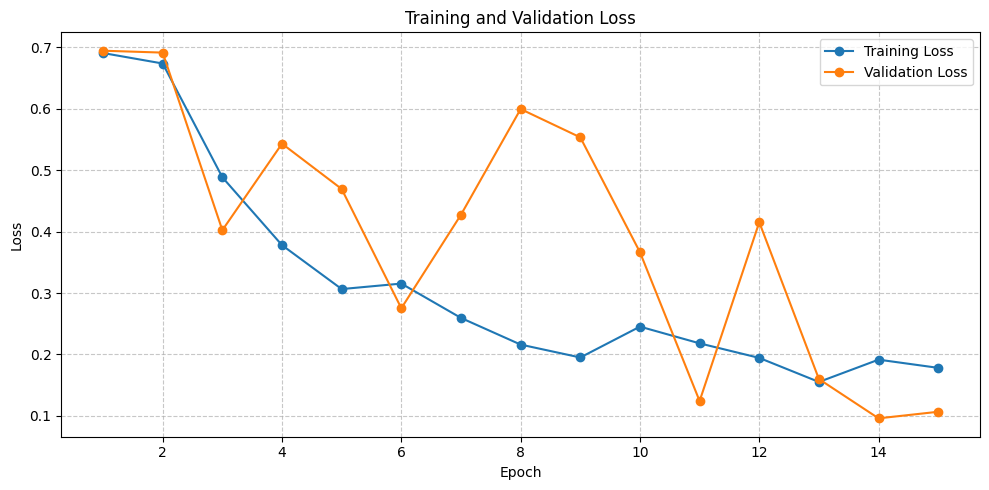

In [ ]:
import matplotlib.pyplot as plt

# Extract the loss data
train_losses = [0.6909550315217127, 0.6738896634005294, 0.4885506374348783, 0.37794083493608046, 0.3064144469652608, 0.31535558837754866, 0.25938988849113326, 0.2159655395558873, 0.19496162161466818, 0.24522989359515467, 0.21798739226865052, 0.19425262642222268, 0.15508671175346628, 0.19142166396966567, 0.17804419388190619]
val_losses = [0.6947389751672745, 0.6916559517738576, 0.40233270972966715, 0.5432875007390976, 0.46945001333395195, 0.27514285631477783, 0.4275522729848758, 0.5997134441985693, 0.5535866640001748, 0.366526791499992, 0.12400721663333476, 0.415349661188294, 0.15979211172088898, 0.09580769496969879, 0.10652607684023678]

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Display the plot
plt.show()